# Marks Molecule Calculations Code

Attempting to remove the seperate handling for phi=0 and phi =/= 0

I didn't really finish this attempt! So this should be reattempt this at some point in the future, but should probably just start again from scratch.

# Startup

## Imports

In [1]:
import numpy as np
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.quantum.cg import CG
import pandas as pd
import math
import scipy.linalg
import IPython.display
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc
import matplotlib.style
matplotlib.style.use('default')
pd.set_option("max_colwidth", 200)

The important import!

In [2]:
import MoleculeCalculation as mol

## Constants

In [3]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


A = 2/V**(3/2)

# Calculations

## Create the relevant bases

### Create Atomic Bases

these are the ordinary single-atom bases that you'd use to describe your atom if you didn't know anything about the molecular symmetries.

In [4]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [3/2])
lsiToJi_Op = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
jiToF_Op = mol.create_jiToF_Op(jiBasis, fBasis)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [3/2], sigmavals=['g', 'u'])
caseASymHfs = mol.createCaseABasis_Sym([1],[0,1],[3/2], sigmavals=['g','u'])

TypeError: createCaseABasis_MostlySym() got an unexpected keyword argument 'sigmavals'

note that as the two particle bases are kronicker-products of the one-particle basis, they include doubly-excited atoms with $L_a = L_b = 1$

In [36]:
structureList = [lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom, caseAMostlySymHfs, caseASymHfs, lsiToJi_Op, jiToF_Op]

basisDesc = pd.DataFrame()
basisDesc["Size"] = [np.array(base).shape for base in structureList]
basisDesc["Keys"] = [str([r"$"+key + "$" for key in base[0].keys()]) for base in structureList[:-2]] + ["N/A", "N/A"]
basisDesc["Example Value"] = [base[0] for base in structureList]
basisDesc.index = ["lsiBasis", "jiBasis", "fBasis", "lsiBasis2Atom", "jiBasis2Atom", "fBasis2Atom", "caseAMostlySymHfs", "caseASymHfs", "lsiToJi_Op", "jiToF_Op"]
display(basisDesc)

,Size,Keys,Example Value
lsiBasis,"(32,)","['$l_x$', '$m_l_x$', '$s_x$', '$m_s_x$', '$i_x$', '$m_i_x$']","{'l_x': 0, 'm_l_x': 0, 's_x': 0.5, 'm_s_x': -0.5, 'i_x': 1.5, 'm_i_x': -1.5}"
jiBasis,"(32,)","['$j_x$', '$m_j_x$', '$l_x$', '$s_x$', '$i_x$', '$m_i_x$']","{'j_x': 0.5, 'm_j_x': -0.5, 'l_x': 0, 's_x': 0.5, 'i_x': 1.5, 'm_i_x': -1.5}"
fBasis,"(32,)","['$f_x$', '$m_f_x$', '$j_x$', '$l_x$', '$s_x$', '$i_x$']","{'f_x': 1.0, 'm_f_x': -1.0, 'j_x': 0.5, 'l_x': 0, 's_x': 0.5, 'i_x': 1.5}"
lsiBasis2Atom,"(1024,)","['$l_a$', '$m_l_a$', '$s_a$', '$m_s_a$', '$i_a$', '$m_i_a$', '$l_b$', '$m_l_b$', '$s_b$', '$m_s_b$', '$i_b$', '$m_i_b$']","{'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'i_a': 1.5, 'm_i_a': -1.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': -0.5, 'i_b': 1.5, 'm_i_b': -1.5}"
jiBasis2Atom,"(1024,)","['$j_a$', '$m_j_a$', '$l_a$', '$s_a$', '$i_a$', '$m_i_a$', '$j_b$', '$m_j_b$', '$l_b$', '$s_b$', '$i_b$', '$m_i_b$']","{'j_a': 0.5, 'm_j_a': -0.5, 'l_a': 0, 's_a': 0.5, 'i_a': 1.5, 'm_i_a': -1.5, 'j_b': 0.5, 'm_j_b': -0.5, 'l_b': 0, 's_b': 0.5, 'i_b': 1.5, 'm_i_b': -1.5}"
fBasis2Atom,"(1024,)","['$f_a$', '$m_f_a$', '$j_a$', '$l_a$', '$s_a$', '$i_a$', '$f_b$', '$m_f_b$', '$j_b$', '$l_b$', '$s_b$', '$i_b$']","{'f_a': 1.0, 'm_f_a': -1.0, 'j_a': 0.5, 'l_a': 0, 's_a': 0.5, 'i_a': 1.5, 'f_b': 1.0, 'm_f_b': -1.0, 'j_b': 0.5, 'l_b': 0, 's_b': 0.5, 'i_b': 1.5}"
caseAMostlySymHfs,"(384,)","['$L$', '$Lambda$', '$sigma$', '$S$', '$Sigma$', '$I$', '$Iota$', '$i_a$', '$i_b$', '$Omega$', '$Phi$']","{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 0, 'Sigma': 0, 'I': 0.0, 'Iota': -0.0, 'i_a': 1.5, 'i_b': 1.5, 'Omega': 0, 'Phi': 0.0}"
caseASymHfs,"(384,)","['$L$', '$|Lambda|$', '$sigma$', '$S$', '$|Sigma|$', '$I$', '$|Iota|$', '$i_a$', '$i_b$', '$|Omega|$', '$Phi$', '$sigma_vxz$', '$sigma_v2xz$']","{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'I': 0.0, '|Iota|': 0.0, 'i_a': 1.5, 'i_b': 1.5, '|Omega|': 0, 'Phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': -1.0}"
lsiToJi_Op,"(32, 32)",N/A,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
jiToF_Op,"(32, 32)",N/A,"[0.0, -0.5, 0.0, 0.0, 0.8660254037844386, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### Create $\phi = 0$ Bases

I need to sort the states in the complete basis "caseASymHfs" by their symmetry label so that I can calculate the different symmetries separately and label them appropriately at the end.

In [63]:
caseASymHfs[0]

{'L': 1,
 '|Lambda|': 1,
 'sigma': 'g',
 'S': 1,
 '|Sigma|': 1,
 'I': 0.0,
 '|Iota|': 0.0,
 'i_a': 1.5,
 'i_b': 1.5,
 '|Omega|': 0,
 'Phi': 0.0,
 'sigma_vxz': -1,
 'sigma_v2xz': -1.0}

In [37]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for phi in np.arange(6):
    for totalSpatialParity in totalSpatialParityIncluded:
        totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
        for state in caseASymHfs:
            sigmaval = mol.g if state['sigma'] == 'g' else mol.u
            if math.isclose(abs(state['Phi']),phi):
                if (-1)**(state['I']+sigmaval) == totalSpatialParityVal:
                    sigmaV2ParityStr = '1' if state['sigma_v2xz'] == 1 else '2'
                    if phi == 0:
                        symmetryLabel = str(phi) + totalSpatialParity + sigmaV2ParityStr
                    else:
                        symmetryLabel = str(phi) + totalSpatialParity
                    if symmetryLabel not in symmetrizedBases:
                        symmetrizedBases[symmetryLabel] = []
                    symmetrizedBases[symmetryLabel].append(state)

### Create $\phi = 1$ through $5$ Bases

In [50]:
phiIncluded=np.arange(1,6)
totalSpatialParityIncluded = ['a','b']
mostlySymmetrizedBases = {}
for phi in phiIncluded:
    for totalSpatialParity in totalSpatialParityIncluded:
        totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
        for state in caseAMostlySymHfs:
            sigmaval = mol.g if state['sigma'] == 'g' else mol.u
            if math.isclose(abs(state['Phi']),phi):
                if (-1)**(state['I']+sigmaval) == totalSpatialParityVal:
                    label = str(phi) + totalSpatialParity
                    if label not in mostlySymmetrizedBases:
                        mostlySymmetrizedBases[label] = []
                    mostlySymmetrizedBases[label].append(state)

## Fine Structure and Hyperfine Structure Hamiltonians

### Create FS and HFS Hamiltonians for the Atomic Bases

In [38]:
fsH = mol.create_fsH(jiBasis2Atom)* 2 * E_FS_5P12_5P32 / 3
hfsH = mol.create_HfsH(fBasis2Atom, E_HFS_5P12_F1F2, E_HFS_5S12_F1F2, mc.Rb87_5P32_ToF3, mc.Rb87_5P32_ToF2, mc.Rb87_5P32_ToF1, mc.Rb87_5P32_ToF0) * mc.h

Why are there six eigenvalues of the fine structure hamiltonian? There are only two fine structure manifolds we are actually considering, $5S_{1/2}+5P_{1/2}$ and $5S_{1/2} + 5P_{3/2}$, but the basis itself includes double-ground state and double excited states, so we also see $5S_{1/2}+5S_{1/2},5P_{1/2}+5P_{1/2}, 5P_{1/2}+5P_{3/2},$ and $ 5P_{3/2}+5P_{3/2}$ energies. There is a similar problem with the hyper-fine structure hamiltonian, where we are only going to work with a limited number of the above energies. If we look at the difference between a certain two of these eigenvalues though...

we can see that the excited state fine-structure splitting is recovered.

### Create FS and HFS Hamiltonians for each molecular symmetry label

In [62]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    #IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        #misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        print(indexes, signs)
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            sigma = mol.g if caseAState["sigma"] == "g" else mol.u
            nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symHfsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op )
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJi_Op )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
        hfsStates.append(symHfsState / np.sqrt(len(indexes)))
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

Working on states of symmetry 0a2. 19 states
[20, 16] [1, -1]
[22, 18] [1, -1]
[0] [1]
[2] [1]
[29, 25] [1, 1]
[31, 27] [1, 1]
[13] [1]
[15] [1]
[33, 39] [1, 1]
[36, 42] [1, -1]
[57, 60] [1, -1]
[44, 50] [1, -1]
[46, 52] [1, -1]
[47, 53] [1, 1]
[49, 55] [1, 1]
[62, 65] [1, 1]
[64, 67] [1, 1]
[68, 70] [1, -1]
[73, 75] [1, 1]
Working on states of symmetry 0a1. 19 states
[20, 16] [1, 1]
[22, 18] [1, 1]
[4] [1]
[6] [1]
[29, 25] [1, -1]
[31, 27] [1, -1]
[9] [1]
[11] [1]
[33, 39] [1, -1]
[36, 42] [1, 1]
[57, 60] [1, 1]
[44, 50] [1, 1]
[46, 52] [1, 1]
[47, 53] [1, -1]
[49, 55] [1, -1]
[62, 65] [1, -1]
[64, 67] [1, -1]
[68, 70] [1, 1]
[73, 75] [1, -1]
Working on states of symmetry 0b1. 19 states
[21, 17] [1, -1]
[23, 19] [1, -1]
[1] [1]
[3] [1]
[28, 24] [1, 1]
[30, 26] [1, 1]
[12] [1]
[14] [1]
[32, 38] [1, 1]
[34, 40] [1, 1]
[35, 41] [1, -1]
[37, 43] [1, -1]
[56, 59] [1, -1]
[58, 61] [1, -1]
[45, 51] [1, -1]
[48, 54] [1, 1]
[63, 66] [1, 1]
[69, 71] [1, -1]
[72, 74] [1, 1]
Working on states of 

#### $\Phi=1-5$

So if you write down the case-A states as $|L Lambda sigma S Sigma I Iota i_a i_b Omega phi$ then you can classify them as phi i kappa, and then I convert fs and hfs states into this base. that's what I'm doing more or less

In [54]:
mostlySymmetrizedBases['1a'][0]

{'L': 1,
 'Lambda': 0,
 'sigma': 'g',
 'S': 0,
 'Sigma': 0,
 'I': 2.0,
 'Iota': -1.0,
 'i_a': 1.5,
 'i_b': 1.5,
 'Omega': 0,
 'Phi': -1.0}

In [51]:
for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [[], []]
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        sigma = mol.g if state["sigma"] == "g" else mol.u
        nuclearNums = [state['I'], state['Iota'],state['i_a'],state['i_b'],]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        fsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJi_Op ));
        hfsStates.append(mol.caseAToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToF_Op@lsiToJi_Op ))
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsH, offset=-1/2 * 2 * E_FS_5P12_5P32 / 3)
    H_hfs_phi[label] = mol.convertH_toCaseABasis( hfsStates, hfsH, offset=0)

Working on states of symmetry 5b. 2 states


## Diagonalize the total energy at all distances.

In [40]:
allBases = {**symmetrizedBases}
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 500 )
energies = {}
for label, base in allBases.items():
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label, '\nCalcualting Eigenvalues at every R')
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        totalEnergy = mol.get_H_BO(C_3_val, rv, base).astype(float) + H_fs_phi[label] + H_hfs_phi[label]
        eigVals, eigVectors = np.linalg.eigh(totalEnergy)
        energies[label][num] = eigVals


Label: 5b 
Calcualting Eigenvalues at every R


### misc

def fsReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    names = ['L', 'mL', 'S', 'mS', 'I', 'mI']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I','mI']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val
    return op

def hfsReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS', 'mI']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val                        
    return op

# Displaying The Results

## Matplotlib Plotting

#### singles picture

In [25]:
def getLabelColorAndLinestyle(label):
    phiColors=['purple','black','green', 'orange','red', '#FF69B4']       
    if label[0] == '0':
        if label[-1] == '1':
            color = 'black'
        elif label[-1] == '2':
            color = '#800080'
    else:
        color = phiColors[int(label[0])]
    linestyle = '-.' if label[1] == 'a' else '-'
    return color, linestyle

#### Zoomed out D1 & D2

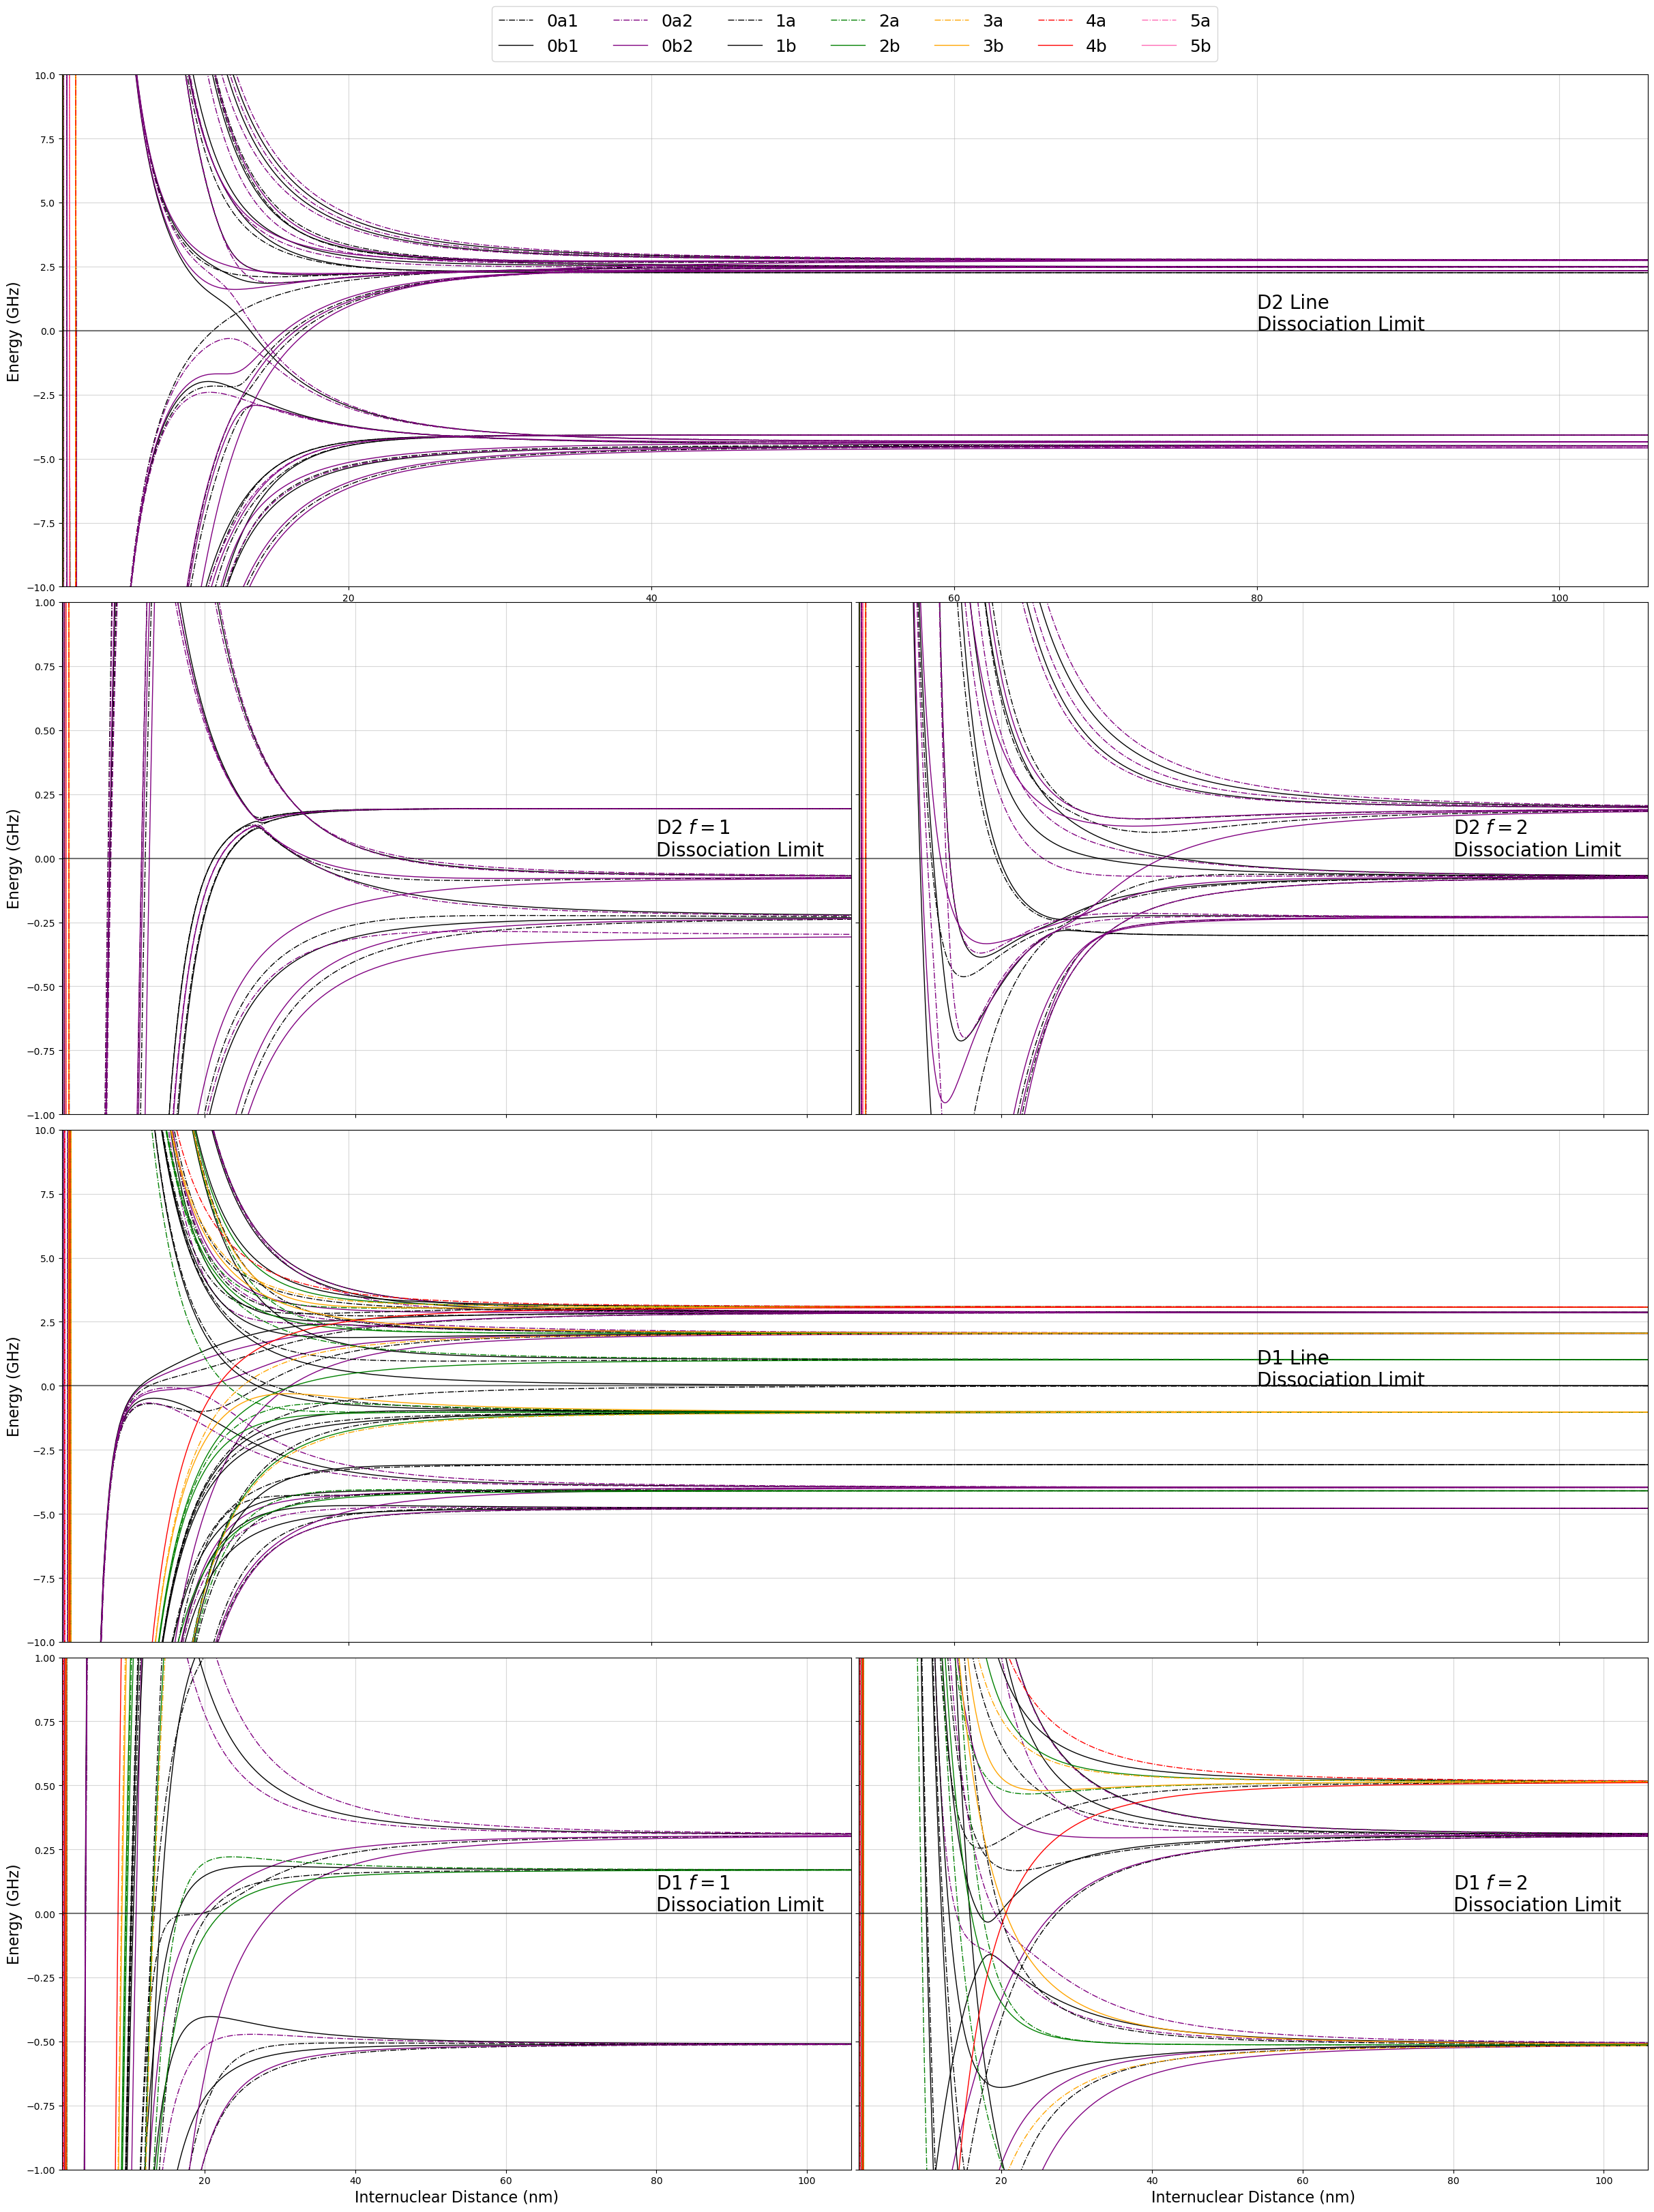

In [48]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,    -mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b','3a','3b','4a','4b','5a','5b']
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for label in labels:
        color, linestyle = getLabelColorAndLinestyle(label)
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    if num == 0:
        leg = ax.legend(fontsize=18, ncol=7, loc='upper center', bbox_to_anchor=(0.5,1.15))
        for text in leg.get_texts():
            text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)', fontsize=16)
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)', fontsize=16)
#plt.savefig("Symmetrized_Hyperfine_Splitting_Big_Picture.svg", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

#### D2 Zoomed In

##### indv

#### D1 Zoomed In

##### indv

##### all

## Plotly Plotting

import plotly.offline as ploff
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot, plot as plotlyplot
import plotly.subplots as ply_subplots
from plotly.tools import make_subplots

ploff.init_notebook_mode(connected=False)

data = []
for label in labels:
    color, linestyle = getLabelColorAndLinestyle(label)
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        data.append(go.Scatter(x=Rvals*1e9, y=np.array(mdata) * 1e-9 / mc.h + yoff))

def getLabelColorAndLinestyle(label):
    phiColors=['purple','blue','green', 'orange','red', '#FF69B4']       
    if label[0] == '0':
        if label[-1] == '1':
            color = 'black'
        elif label[-1] == '2':
            color = '#800080'
    else:
        color = phiColors[int(label[0])]
    linestyle = 'dash' if label[1] == 'b' else 'solid'
    return color, linestyle

### Plotly Zoomed Out

titles = ["D2 Line",  
          "D2 f=1",     "D2 f=2",
          "D1 Line",  
          "D1 f=1",     "D1 f=2"]
allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            E_FS_5P12_5P32/mc.h,
            E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF1,E_FS_5P12_5P32/mc.h-mc.Rb87_Ground_ToF2])/1e9
n = None
r = 'rowspan'
c = 'colspan'
fig = ply_subplots.make_subplots(rows=4, cols=2, print_grid=False, horizontal_spacing=0.01, vertical_spacing=0.01,
    specs=[[{r: 1, c: 2}, n],
           [{r: 1, c: 1}, {r: 1, c: 1}],
           [{r: 1, c: 2}, n],
           [{r: 1, c: 1}, {r: 1, c: 1}]])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1500,
    paper_bgcolor='white',
    plot_bgcolor='white', legend=dict(font={'size':8}, yanchor="bottom", y=1.005, xanchor="right", x=1), legend_orientation="h")
inc=1

axCoord = [[1,1],[2,1],[2,2],[3,1],[4,1],[4,2]]
labels = ['0a1','0b1','0a2','0b2','1a','1b','2a','2b','3a','3b','4a','4b','5a','5b']
for num, (ax, title, ylims, yoff) in enumerate(zip(axCoord, titles, allYlims, yoffsets)):
    for label in labels[:]:
        color, linestyle = getLabelColorAndLinestyle(label)
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            fig.add_trace(
                go.Scatter(x=Rvals*1e9, y=np.array(mdata) * 1e-9 / mc.h + yoff, 
                           mode='lines', name=label, line={'color': color, 'width': 1, 'dash':linestyle},
                           legendgroup=label, showlegend=True if datanum==0 and num==0 else False), 
                          ax[0],ax[1])
    fig['layout']['yaxis'+str(num+1)].update(range=ylims)
    fig['layout']['xaxis'+str(num+1)].update(range=[min(Rvals)*1e9,max(Rvals)*1e9])
    fig.add_trace(go.Scatter( x=[80], y=[0], mode="text", text=[title + "\nDissociation Limit"],
                  textposition="top center",showlegend=False),row=ax[0],col=ax[1])
    fig.add_shape(type='line',x0=0,y0=0,x1=1,y1=0,
                  line=dict(color='Red',), xref='x', row=ax[0],col=ax[1])
    if num in [4,5]:
        fig.update_xaxes(title_text='Internuclear Distance (nm)', row=ax[0],col=ax[1])
    if num in [1,2,3]:
        fig.update_xaxes(showticklabels=False, row=ax[0],col=ax[1])
    if num not in [0, 1, 3, 4]:
        fig.update_yaxes(showticklabels=False, row=ax[0],col=ax[1])
    else:
        fig.update_yaxes(title_text='Energy (GHz)', row=ax[0], col=ax[1])
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True, showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True,showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.write_html("Zoomed_Out.html")
fig.show()

### Plotly D2 Zoomed In

fig = ply_subplots.make_subplots(rows=4, cols=2, print_grid=False, horizontal_spacing=0.01, vertical_spacing=0.01,
    specs=[[{r: 1, c: 1}, {r: 1, c: 1}],
           [{r: 1, c: 1}, {r: 1, c: 1}],
           [{r: 1, c: 1}, {r: 1, c: 1}],
           [{r: 1, c: 1}, {r: 1, c: 1}]])
titles = [
          r"D2 f=1,f'=3",r"D2 f=2,f'=3",
          r"D2 f=1,f'=2",r"D2 f=2,f'=2",
          r"D2 f=1,f'=1",r"D2 f=2,f'=1",
          r"D2 f=1,f'=0",r"D2 f=2,f'=0"]
allYlims = [
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),]
yoffsets = np.array(
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF3,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF3,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF1,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF0,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF0])/1e9
axCoord = [[1,1],[1,2],[2,1],[2,2],[3,1],[3,2],[4,1],[4,2]]
fig.update_layout(
    autosize=False,
    width=1000,
    height=1500,
    paper_bgcolor='white',
    plot_bgcolor='white', legend=dict(font={'size':8}, yanchor="bottom", y=1.005, xanchor="right", x=1), legend_orientation="h")
inc=1
for num, (ax, title, ylims, yoff) in enumerate(zip(axCoord, titles, allYlims, yoffsets)):
    for label in labels[:]:
        color, linestyle = getLabelColorAndLinestyle(label)
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            fig.add_trace(
                go.Scatter(x=Rvals*1e9, y=np.array(mdata) * 1e-9 / mc.h + yoff, 
                           mode='lines', name=label, line={'color': color, 'width': 1, 'dash':linestyle},
                           legendgroup=label, showlegend=True if datanum==0 and num==0 else False), 
                           ax[0],ax[1])
    fig['layout']['yaxis'+str(num+1)].update(range=ylims)
    fig['layout']['xaxis'+str(num+1)].update(range=[min(Rvals)*1e9,max(Rvals)*1e9])
    fig.add_trace(go.Scatter( x=[80], y=[0], mode="text", text=[title + "\nDissociation Limit"],
                  textposition="top center",showlegend=False),row=ax[0],col=ax[1])
    fig.add_shape(type='line',x0=0,y0=0,x1=1,y1=0,
                  line=dict(color='Red',), xref='x', row=ax[0],col=ax[1])
    if num in [6,7]:
        fig.update_xaxes(title_text='Internuclear Distance (nm)', row=ax[0],col=ax[1])
    else:
        fig.update_xaxes(showticklabels=False, row=ax[0],col=ax[1])
    if num not in [0, 2, 4, 6]:
        fig.update_yaxes(showticklabels=False, row=ax[0],col=ax[1])
    else:
        fig.update_yaxes(title_text='Energy (GHz)', row=ax[0], col=ax[1])
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True, showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True,showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.write_html("D2_Zoom.html")
fig.show()

### Plotly D1 Zoomed In

titles = [r"D1 f=1,f'=2",r"D1 f=2,f'=2",
          r"D1 f=1,f'=1",r"D1 f=2,f'=1"]
fig = ply_subplots.make_subplots(rows=2, cols=2, print_grid=False, horizontal_spacing=0.01, vertical_spacing=0.01,
    specs=[[{r: 1, c: 1}, {r: 1, c: 1}],
           [{r: 1, c: 1}, {r: 1, c: 1}]])
allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += E_FS_5P12_5P32/mc.h/1e9
axCoord = [[1,1],[1,2],[2,1],[2,2],[3,1],[3,2]]
fig.update_layout(
    autosize=False, width=1000, height=750, paper_bgcolor='white', plot_bgcolor='white', 
    legend=dict(font={'size':8}, yanchor="bottom", y=1.005, xanchor="right", x=1), legend_orientation="h")
inc=1
for num, (ax, title, ylims, yoff) in enumerate(zip(axCoord, titles, allYlims, yoffsets)):
    for label in labels[:]:
        color, linestyle = getLabelColorAndLinestyle(label)
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            fig.add_trace(
                go.Scatter(x=Rvals*1e9, y=np.array(mdata) * 1e-9 / mc.h + yoff, 
                           mode='lines', name=label, line={'color': color, 'width': 1, 'dash':linestyle},
                           legendgroup=label, showlegend=True if datanum==0 and num==0 else False), 
                          ax[0],ax[1])
    fig['layout']['yaxis'+str(num+1)].update(range=ylims)
    fig['layout']['xaxis'+str(num+1)].update(range=[min(Rvals)*1e9,max(Rvals)*1e9])
    fig.add_trace(go.Scatter( x=[80], y=[0.05], mode="text", text=[title + "\nDissociation Limit"],
                  textposition="top center",showlegend=False),row=ax[0],col=ax[1])
    fig.add_shape(type='line',x0=0,y0=0,x1=1,y1=0,
                  line=dict(color='Red',), xref='x', row=ax[0],col=ax[1])
    if num in [4,5]:
        fig.update_xaxes(title_text='Internuclear Distance (nm)', row=ax[0],col=ax[1])
    else:
        fig.update_xaxes(showticklabels=False, row=ax[0],col=ax[1])
    if num not in [0, 2, 4, 6]:
        fig.update_yaxes(showticklabels=False, row=ax[0],col=ax[1])
    else:
        fig.update_yaxes(title_text='Energy (GHz)', row=ax[0], col=ax[1])
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True, showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,50)',
                mirror=True,showline=True, linecolor='black',
                zeroline=True, zerolinecolor='black')
fig.write_html("D1_Zoom.html")
fig.show()

V = 100e3
U = A * V**(3/2)
print(U)